# **TRABALHO T2**

Estudo Introdutório a Recomendações e ao Algoritmo K-Nearest Neighbors
Este notebook apresenta um estudo referente à metodologias de recomendação de filmes a um determinado usuário, seguindo diferentes heurísticas para tal.
O dataset utilizado para este estudo pode ser encontrado no seguinte link do site GroupLens: https://grouplens.org/datasets/movielens/latest/.

***UTILIZE O MAIOR DATASET DISPONÍVEL NESTE LINK PARA FAZER O TRABALHO!***

In [ ]:
# Importando bibliotecas necessárias para o estudo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Lendo o dataset relacionado aos filmes
movies = pd.read_csv("dados/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),Action|Drama
86533,288971,Ouija Japan (2021),Action|Horror
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary
86535,288977,Skinford: Death Sentence (2023),Crime|Thriller


In [ ]:
# Transformando coluna movieID em índice
movies.set_index('movieId', inplace = True)
movies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
288967,State of Siege: Temple Attack (2021),Action|Drama
288971,Ouija Japan (2021),Action|Horror
288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary


Conhecendo o Dataframe
O Dataframe 'movies' possui informações a respeito dos filmes analisados, sendo estas:

**MovieId**: Identificação única de cada filme.

**title**: O título de cada filme, junto com o ano de lançamento.

**genres**: O gênero, ou conjunto de gêneros, de cada filme.


In [ ]:
# Lendo o dataset relacionado às avaliações dos usuários
ratings = pd.read_csv("dados/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119
...,...,...,...,...
33832157,330975,8340,2.0,1091583256
33832158,330975,8493,2.5,1091585709
33832159,330975,8622,4.0,1091581777
33832160,330975,8665,3.0,1091581765


In [ ]:
ratings.shape

(33832162, 4)

In [ ]:
# Transformando coluna userId em índice
ratings.set_index('userId', inplace = True)
ratings

,movieId,rating,timestamp
userId,,,
1,1,4.0,1225734739
1,110,4.0,1225865086
1,158,4.0,1225733503
1,260,4.5,1225735204
1,356,5.0,1225735119
...,...,...,...
330975,8340,2.0,1091583256
330975,8493,2.5,1091585709
330975,8622,4.0,1091581777


Conhecendo o segundo dataframe
O Dataframe 'ratings' possui informações a respeito das análises feitas pelos usuários, sendo estas:

**userId**: Identificação única de cada usuário presente no dataframe.

**movieId**: Identificação única de cada filme presente no dataframe 'movies', visto anteriormente.

**rating**: A avaliação feita por aquele usuário àquele filme específico.

**timestamp**: De acordo com o site MovieLens (https://files.grouplens.org/datasets/movielens/ml-10m-README.html), representam os segundos que se passaram desde a meia-noite(UTC) do dia 1º de Janeiro de 1970

In [ ]:
# Informações a respeito das avaliações informadas pelos usuários
ratings.rating.describe().round(2)

count    33832162.00
mean            3.54
std             1.06
min             0.50
25%             3.00
50%             4.00
75%             4.00
max             5.00
Name: rating, dtype: float64

In [ ]:
# Número de usuários contidos dentro do dataset
ratings.index.nunique()

330975

## **1. Primeira Tentativa de Recomendação**

Sem ter qualquer tipo de informação prévia a respeito do usuário e seus gostos, podemos recomendá-lo dez filmes de acordo com duas diferentes métricas:

1º - Os dez filmes mais avaliados.

2º - Os dez filmes mais bem avaliados.

In [ ]:
# Vamos avaliar as informações das notas de acordo com os filmes
# Utilizando o método value_counts(), podemos identificar os filmes que mais receberam avaliações
ratings['movieId'].value_counts()

movieId
318       122296
356       113581
296       108756
2571      107056
593       101802
           ...  
261715         1
257463         1
256693         1
161766         1
269782         1
Name: count, Length: 83239, dtype: int64

In [ ]:
# O filme mais avaliado do dataset é o 318. Buscamos no índice por esse movieId
movies.loc[[318]]

,title,genres
movieId,,
318,"Shawshank Redemption, The (1994)",Crime|Drama


In [ ]:
# Criando coluna que contabiliza o número de avaliações
movies['number_of_ratings'] = ratings['movieId'].value_counts()

# Criando coluna que calcula a nota média de avaliações e definindo duas casas decimais de
# arredondamento.
movies['average_ratings'] = ratings.groupby('movieId').rating.mean().round(2)

# Visualizando o Dataframe
movies

,title,genres,number_of_ratings,average_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,76813.0,3.89
2,Jumanji (1995),Adventure|Children|Fantasy,30209.0,3.28
3,Grumpier Old Men (1995),Comedy|Romance,15820.0,3.17
4,Waiting to Exhale (1995),Comedy|Drama|Romance,3028.0,2.87
5,Father of the Bride Part II (1995),Comedy,15801.0,3.08
...,...,...,...,...
288967,State of Siege: Temple Attack (2021),Action|Drama,1.0,3.50
288971,Ouija Japan (2021),Action|Horror,1.0,0.50
288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,1.0,4.00


# **1.1. Recomendando os dez filmes mais avaliados**

In [ ]:
# Para visualizarmos os dez filmes mais avaliados, basta utilizarmo o método sort_values()
# e ordenarmos o dataframe pela coluna 'number_of_ratings' de forma decrescente.
movies.sort_values('number_of_ratings', ascending = False).head(10)

,title,genres,number_of_ratings,average_ratings
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,122296.0,4.42
356,Forrest Gump (1994),Comedy|Drama|Romance|War,113581.0,4.07
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,108756.0,4.19
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,107056.0,4.16
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,101802.0,4.15
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,97202.0,4.09
2959,Fight Club (1999),Action|Crime|Drama|Thriller,86207.0,4.24
527,Schindler's List (1993),Drama|War,84232.0,4.24
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,83026.0,3.69


Utilizando como base o número total de avaliações, os dez primeiros filmes que podemos indicar a um novo usuário são os listados acima!

## **1.2. Recomendando os dez filmes mais bem avaliados**

In [ ]:
# Para visualizar os dez filmes mais bem avaliados, basta usar o mesmo método sort_values()
# para ordenar a coluna 'average_ratings' de forma decrescente.
# Entretanto, é necessário filtrar a coluna 'number_of_ratings', definindo um número mínimo
# de avaliações que um filme deva ter para aparecer no Dataframe, evitando que filmes de nicho,
# pouco avaliados, apareçam como mais bem votados.

# Definimos um número mínimo de avaliações de 1000
movies.query('number_of_ratings >= 1000').sort_values('average_ratings', ascending = False).head(10)

,title,genres,number_of_ratings,average_ratings
movieId,,,,
171011,Planet Earth II (2016),Documentary,2041.0,4.45
159817,Planet Earth (2006),Documentary,3015.0,4.45
170705,Band of Brothers (2001),Action|Drama|War,2835.0,4.42
318,"Shawshank Redemption, The (1994)",Crime|Drama,122296.0,4.42
858,"Godfather, The (1972)",Crime|Drama,75004.0,4.33
202439,Parasite (2019),Comedy|Drama,12399.0,4.33
179135,Blue Planet II (2017),Documentary,1267.0,4.31
198185,Twin Peaks (1989),Drama|Mystery,1132.0,4.30
1221,"Godfather: Part II, The (1974)",Crime|Drama,47271.0,4.27


## **2. Recomendação pela Similaridade de Gênero**

Presumindo que sabemos que o usuário já assitiu alguns filmes e que os IDs destes filmes são 1,21,19,10,11,7 e 2, podemos utilizar esta informação para indicar a ele novos filmes de gêneros similares àqueles que ele assistiu, sem levar em conta, entretanto, suas avaliações a respeito destes filmes!

In [ ]:
# Criando uma lista de filmes assistidos
watched_movies = [1,21,19,10,11,7,2]
# Visualizando quais filmes são estes
movies.loc[watched_movies]

,title,genres,number_of_ratings,average_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,76813.0,3.89
21,Get Shorty (1995),Comedy|Crime|Thriller,26183.0,3.57
19,Ace Ventura: When Nature Calls (1995),Comedy,26642.0,2.67
10,GoldenEye (1995),Action|Adventure|Thriller,34942.0,3.43
11,"American President, The (1995)",Comedy|Drama|Romance,20256.0,3.66
7,Sabrina (1995),Comedy|Romance,15596.0,3.37
2,Jumanji (1995),Adventure|Children|Fantasy,30209.0,3.28


**Filmes de Gênero Similares**

Observando que o último filme assistido, Jumanji, encontra-se na categoria Adventure|Children|Fantasy, buscamos filmes de categorias similares e recomendamos ao usuário estes filmes ordenando-os de acordo com a média de avaliações, também filtrando o número de avaliações, evitando recomendar filmes pouco avaliados.

In [ ]:
# Buscamos filmes que tenham, no minimo, 100 avaliações dentro da categoria.
# Método drop() utilizado para evitar que o usuário receba recomendações de filmes já assistidos.
movies.query("genres == 'Adventure|Children|Fantasy'").query('number_of_ratings >= 100').sort_values(
'average_ratings', ascending = False).drop(watched_movies, errors = 'ignore').head(10)

,title,genres,number_of_ratings,average_ratings
movieId,,,,
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,36127.0,3.70
2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy,13617.0,3.52
80748,Alice in Wonderland (1933),Adventure|Children|Fantasy,125.0,3.52
50601,Bridge to Terabithia (2007),Adventure|Children|Fantasy,2697.0,3.44
41566,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure|Children|Fantasy,17042.0,3.39
2043,Darby O'Gill and the Little People (1959),Adventure|Children|Fantasy,1217.0,3.28
82169,Chronicles of Narnia: The Voyage of the Dawn T...,Adventure|Children|Fantasy,2968.0,3.28
59501,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure|Children|Fantasy,4646.0,3.19
160573,Pete's Dragon (2016),Adventure|Children|Fantasy,458.0,3.16


# **3. Recomendações por Similaridades Entre Usuários**

**Calculando a distância euclidiana**

Outra abordagem que podemos utilizar é a recomendação através da similaridade entre usuários.
Sabendo que João, Maria e Joana assistiram, cada um, os mesmos dois filmes (x e y) e os avaliaram, podemos realizar o cálculo da distância euclidiana entre estes três usuários por meio do teorema de Pitágoras para identificarmos a similaridade entre seus gostos.

Text(0.5, 1.0, 'Calculando a distância entre dois usuários')

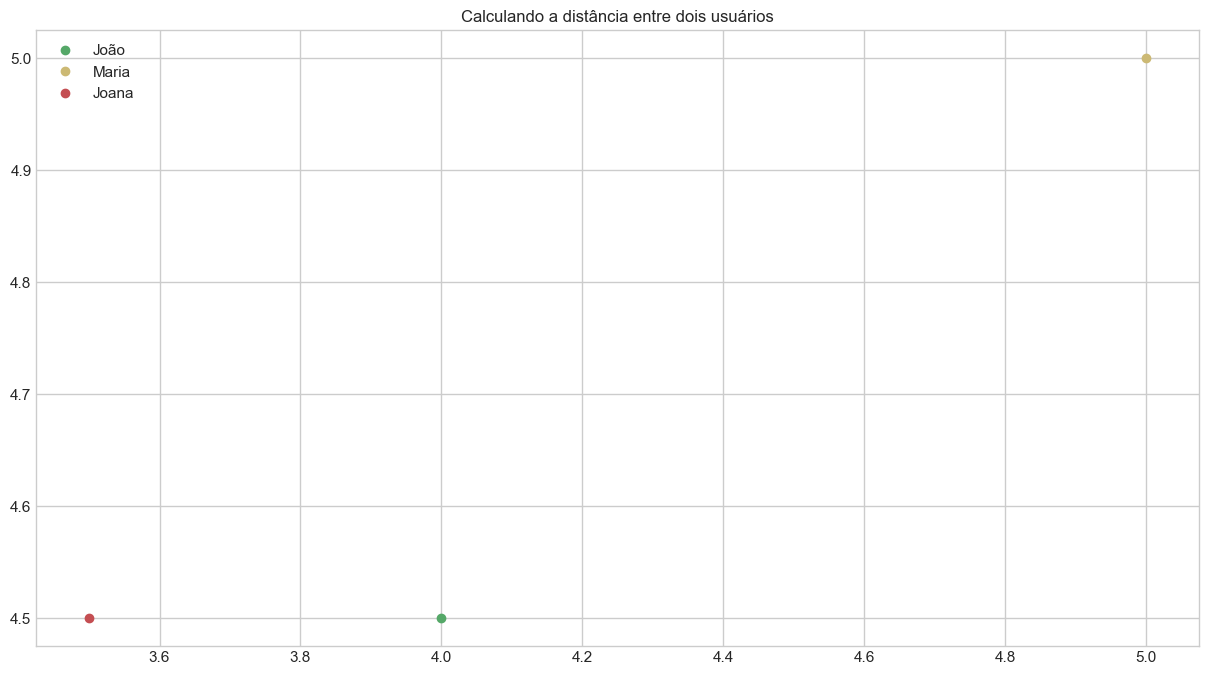

In [ ]:
# Vamos supor que João, Maria e Joana fizeram as seguintes avaliações dos mesmos filmes
joao = np.array([4,4.5])
maria = np.array([5,5])
joana = np.array([3.5,4.5])

# Podemos plotar em um gráfico para visualizarmos as diferentes avaliações por cada um deles
plt.figure(figsize=(15,8))
plt.plot(4, 4.5,"go") # Avaliações de João representadas por um círculo verde
plt.plot(5, 5,"yo") # Avaliações de Maria representadas por um círculo amarelo
plt.plot(3.5,4.5,"ro") # Avaliações de Joana representadas por um círculo vermelho
plt.legend(['João','Maria','Joana'])
plt.title("Calculando a distância entre dois usuários")

Sabendo as avaliações de cada um dos três usuários, podemos utilizar o método linalg.norm() do Numpy para calcularmos as distâncias euclidianas entre eles.

In [ ]:
# Criando função que faça o cálculo da distância euclidiana
def distance(a,b):
    return round(np.linalg.norm(a - b), 2) # método round para exibir apenas 2 números decimais

In [ ]:
# Medindo as distâncias entre João, Maria e Joana
print(f'A distância de João e Maria é de {distance(joao,maria)}')
print(f'A distância de João e Joana é de {distance(joao,joana)}')

A distância de João e Maria é de 1.12
A distância de João e Joana é de 0.5


Através do cálculo da distância euclidiana entre João, Maria e Joana, podemos perceber que Joana está muito mais próxima de João do que de Maria, ou seja, João e Maria possuem gostos similares, de acordo com suas avaliações dos mesmos filmes.
Sabendo de tal similaridade, faz sentido recomendar à Joana os filmes que João assistiu e gostou.

**3.1. Aplicando o Cálculo de Distância Euclidiana em Dois Usuários do Dataset**

Vamos supor que queremos recomendar filmes ao userId 1 e vamos calcular qual é a sua distância do userId 4.

In [ ]:
# Definindo função para extrair informaçoes a respeito das avaliações de cada usuário
def user_ratings(userId):
    user_ratings = ratings.query('userId == %d' % userId)[['movieId','rating']].set_index('movieId')
    return user_ratings

In [ ]:
# Testando a função e extraindo o movieId e a avaliação do userId 1 de cada filme indexado
user_ratings(1)

,rating
movieId,
1,4.0
110,4.0
158,4.0
260,4.5
356,5.0
...,...
40629,4.5
49647,5.0
52458,5.0


In [ ]:
# Extraindo as avaliações do userId 4
user_ratings(4)

,rating
movieId,
260,5.0
318,5.0
356,5.0
595,4.5
858,3.0
915,4.0
1097,3.5
2324,5.0
2858,4.0


In [ ]:
# Definindo uma função que extraia as avaliações de dois userIds informados, junte-os em um mesmo
# dataframe e calcule a distância euclidiana entre eles

def euclidean_distance(userId1,userId2):
    userId1_ratings = user_ratings(userId1)
    userId2_ratings = user_ratings(userId2)
    join_df = userId1_ratings.join(userId2_ratings, lsuffix = '_user1',
                                  rsuffix = '_user2').dropna()
    distance_users = distance(join_df.rating_user1,join_df.rating_user2)
    return print(f'A distância entre o usuário {userId1} e {userId2} é {distance_users}')

In [ ]:
# Calculando a distância entre o userId 1 e userId 4
euclidean_distance(1,4)

A distância entre o usuário 1 e 4 é 1.32


# **4. Algoritmo K-Nearest Neighbors**

O K-nearest neighbors, podendo ser chamado também de 'K-vizinhos mais próximos' é um algoritmo de machine learning muito usado para realizar classificações.
Supondo que tenhamos o seguinte conjunto de dados, dividido em duas classes: azul e vermelho, e temos um dado específico que não está classificado, identificado pela cor verde na imagem abaixo:
knn.jpg
O algoritmo KNN é utilizado para calcular as distâncias entre este dado não-categorizado com os K-vizinhos mais próximos, ou seja, os vizinhos cuja distância sejam menores.
No caso da imagem acima, se informarmos o parâmetro K = 3, o algoritmo irá calcular a distância entre o dado não-categorizado com os três dados categorizados mais próximos e, neste caso, irá categorizar o dado verde como sendo pertencente à classe vermelha.

O algoritmo KNN é utilizado para calcular as distâncias entre este dado não-categorizado com os K-vizinhos mais próximos, ou seja, os vizinhos cuja distância sejam menores.
No caso da imagem acima, se informarmos o parâmetro K = 3, o algoritmo irá calcular a distância entre o dado não-categorizado com os três dados categorizados mais próximos e, neste caso, irá categorizar o dado verde como sendo pertencente à classe vermelha.

<img src="imagens/knn.png" width="500" height="400">

<img src="imagens/knn2.png" width="500" height="400">

A distância euclidiana é uma das mais usadas no algoritmo KNN para calcular a distância entre dados de um conjunto e, utilizando as funções anteriores criadas neste estudo, podemos definir novas funções, construindo um algoritmo KNN do zero, para identificar usuários com gostos similares em nosso dataset e recomendar filmes se baseando no grau de proximidade entre eles.

In [ ]:
# Refinando a função euclidean_distance() para filtrar usuários que sejam muito distantes, ou
# usuários que não tenham nenhum filme em comum avaliados.
# 'minimum' se refere a quantidade mínima de filmes avaliados entre usuários diferentes
def euclidean_distance(userId1,userId2, minimum = 5):
    userId1_ratings = user_ratings(userId1)
    userId2_ratings = user_ratings(userId2)
    join_df = userId1_ratings.join(userId2_ratings, lsuffix = '_user1',
                                  rsuffix = '_user2').dropna()

    if(len(join_df) < minimum):
        return None

    distance_users = distance(join_df.rating_user1,join_df.rating_user2)
    return [userId1, userId2, distance_users]

In [ ]:
# Definindo função que faça o cálculo da distância de diversos usuários
# Considerando que há um número muito alto de usuários, o parâmetro users_to_verify pode ser
# usado para definir o número de usuários que serão verificados para calcular a distância dentro
# do dataframe.
# ex: se users_to_verify = 50, apenas os 50 primeiros usuários do dataframe serão verificados
def distance_from_all(informed_user, users_to_verify = None):
    all_users = ratings.index.unique()
    if users_to_verify:
        all_users = all_users[:users_to_verify]
    distance_all_users = [euclidean_distance(informed_user,userId) for userId in all_users]
    distance_all_users = list(filter(None, distance_all_users))
    distance_all_users = pd.DataFrame(distance_all_users, columns = ['informed_user','others','distance'])
    return distance_all_users

In [ ]:
# Definindo função que calcule a distância dos K-vizinhos mais próximos
# k_nearest_neighbors é o parâmetro que deve ser dado para informar quais vizinhos mais próximos
# serão analizados. Por padrão, o algoritmo irá verificar apenas os 10 vizinhos mais próxmos, ou
# seja, os 10 usuários mais similares ao usuário informado
def knn(informed_user, k_nearest_neighbors = 10, users_to_verify = None):
    distance_users = distance_from_all(informed_user, users_to_verify = users_to_verify)
    distance_users = distance_users.sort_values('distance')
    distance_users = distance_users.set_index('others').drop(informed_user, errors = 'ignore')
    return distance_users.head(k_nearest_neighbors)

In [ ]:
# Definindo função de sugestões
def suggestions_for_user(informed_user, k_nearest_neighbors = 10, users_to_verify = None):
    informed_user_ratings = user_ratings(informed_user)
    movies_seen_by_informed_user = informed_user_ratings.index

    similar = knn(informed_user, k_nearest_neighbors=k_nearest_neighbors,users_to_verify=users_to_verify)
    similar_users = similar.index
    similar_users_ratings = ratings.loc[similar_users]
    recommendations = round(similar_users_ratings.groupby('movieId').mean()[['rating']], 2)
    fequency = similar_users_ratings.groupby('movieId').count()[['rating']]

   #minimum_filter cria um filtro para mostrar apenas títulos que tenham sido avaliados por,
   # no mínimo, a metade dos k-vizinhos mais próximos
    minimum_filter = k_nearest_neighbors / 2
    recommendations = recommendations.join(fequency, lsuffix = '_mean_others',rsuffix='_frequency_others')
    recommendations = recommendations.query('rating_frequency_others >= %.2f' % minimum_filter)
    recommendations = recommendations.sort_values('rating_mean_others', ascending = False)
    recommendations = recommendations.drop(movies_seen_by_informed_user, errors = 'ignore')
    return recommendations.join(movies)

In [ ]:
# Testando as recomendações para o usuário 1, analizando os primeiros 500 usuários do dataframe
# Por definição, os k-vizinhos mais próximos dos 500 primeiros usuários são os 10 usuários
# mais próximos cujas avaliações serão relevantes para a recomendação.
#head(10) exibe os dez filmes ordenados pela avaliação média dos K-Vizinhos mais próximos.
suggestions_for_user(1,users_to_verify=500).head(10)

,rating_mean_others,rating_frequency_others,title,genres,number_of_ratings,average_ratings
movieId,,,,,,
318,4.3,5,"Shawshank Redemption, The (1994)",Crime|Drama,122296.0,4.42
858,4.3,5,"Godfather, The (1972)",Crime|Drama,75004.0,4.33
2858,4.0,5,American Beauty (1999),Drama|Romance,69902.0,4.10


# **OBSERVAÇÃO**

A função suggestion_for_user recebe como parâmetro o userId do usuário que desejamos recomendar os filmes, os k-vizinhos mais próximos - k_nearest_neighbors(10 por padrão) e a quantidade de usuários para terem suas distâncias calculadas dentro do dataset -users_to_verify(por padrão, todo o dataset é incluído).
O dataframe de recomendações recebeu duas novas colunas, sendo elas a rating_mean_others, que representa a média de avaliações dos k-vizinhos mais próximos, e rating_frequency_others, que mostra quantos usuários, dentre os k-vizinhos, avaliaram aquele filme.
O dataframe também é organizado pela média das avaliações dos k-vizinhos, em ordem decrescente, e a frequência mínima estabelecida para que o filme seja recomendado é de 5, ou seja, ele deve ter sido avaliado por ao menos metade dos k-vizinhos selecionados.
Neste contexto, calculando as distâncias de 500 usuários, encontrando os mais similares ao userID 1 de acordo com suas próprias avaliações, os dez filmes não vistos pelos userId 1 que podemos recomendar a ele são os listados na célula anerior.

# Complementos

In [ ]:
# Configuração de estilo
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')
get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
# Informações básicas
print("🎬 Número total de filmes:", movies.shape[0])
print("👤 Número total de usuários:", ratings.index.nunique())
print("⭐ Número total de avaliações:", ratings.shape[0])
print("\n📅 Período das avaliações:")
print("Data mais antiga:", pd.to_datetime(ratings['timestamp'], unit='s').min())
print("Data mais recente:", pd.to_datetime(ratings['timestamp'], unit='s').max())

🎬 Número total de filmes: 86537
👤 Número total de usuários: 330975
⭐ Número total de avaliações: 33832162

📅 Período das avaliações:
Data mais antiga: 1995-01-09 11:46:44
Data mais recente: 2023-07-20 08:53:33


In [ ]:
# Pré-processamento
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.drop('timestamp', axis=1, inplace=True)

In [ ]:
# Adicionando informações de contagem e média de avaliações aos filmes
movie_stats = ratings.groupby('movieId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).round(2)
movies = movies.join(movie_stats)

In [ ]:
# Estatísticas descritivas
print("📊 Estatísticas das avaliações:")
print(ratings['rating'].describe())

📊 Estatísticas das avaliações:
count    3.383216e+07
mean     3.542540e+00
std      1.063959e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


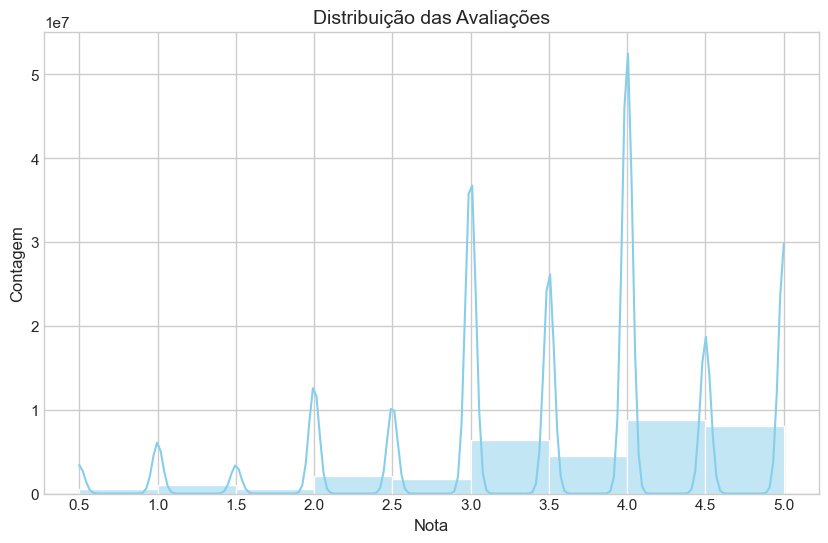

In [ ]:
# Plotando distribuição
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=9, kde=True, color='skyblue')
plt.title('Distribuição das Avaliações', fontsize=14)
plt.xlabel('Nota', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.show()


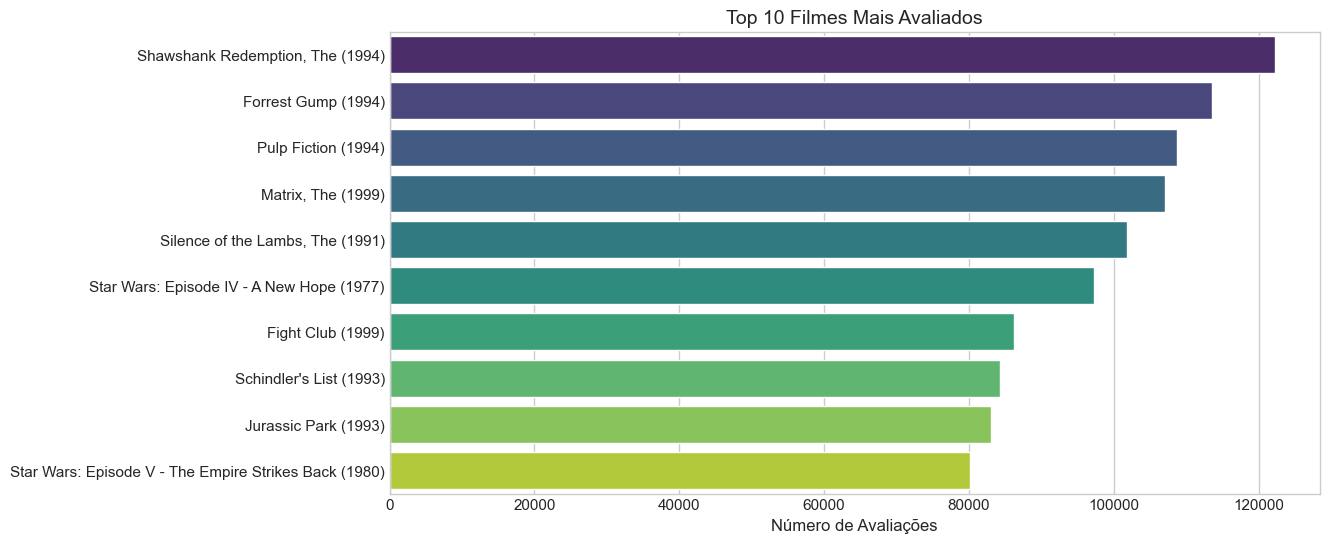

In [ ]:
# Top 10 filmes mais avaliados
top_rated = movies.sort_values('num_ratings', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='num_ratings', y='title', hue='title', data=top_rated.reset_index() ,palette='viridis')
plt.title('Top 10 Filmes Mais Avaliados', fontsize=14)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.ylabel('')
plt.show()


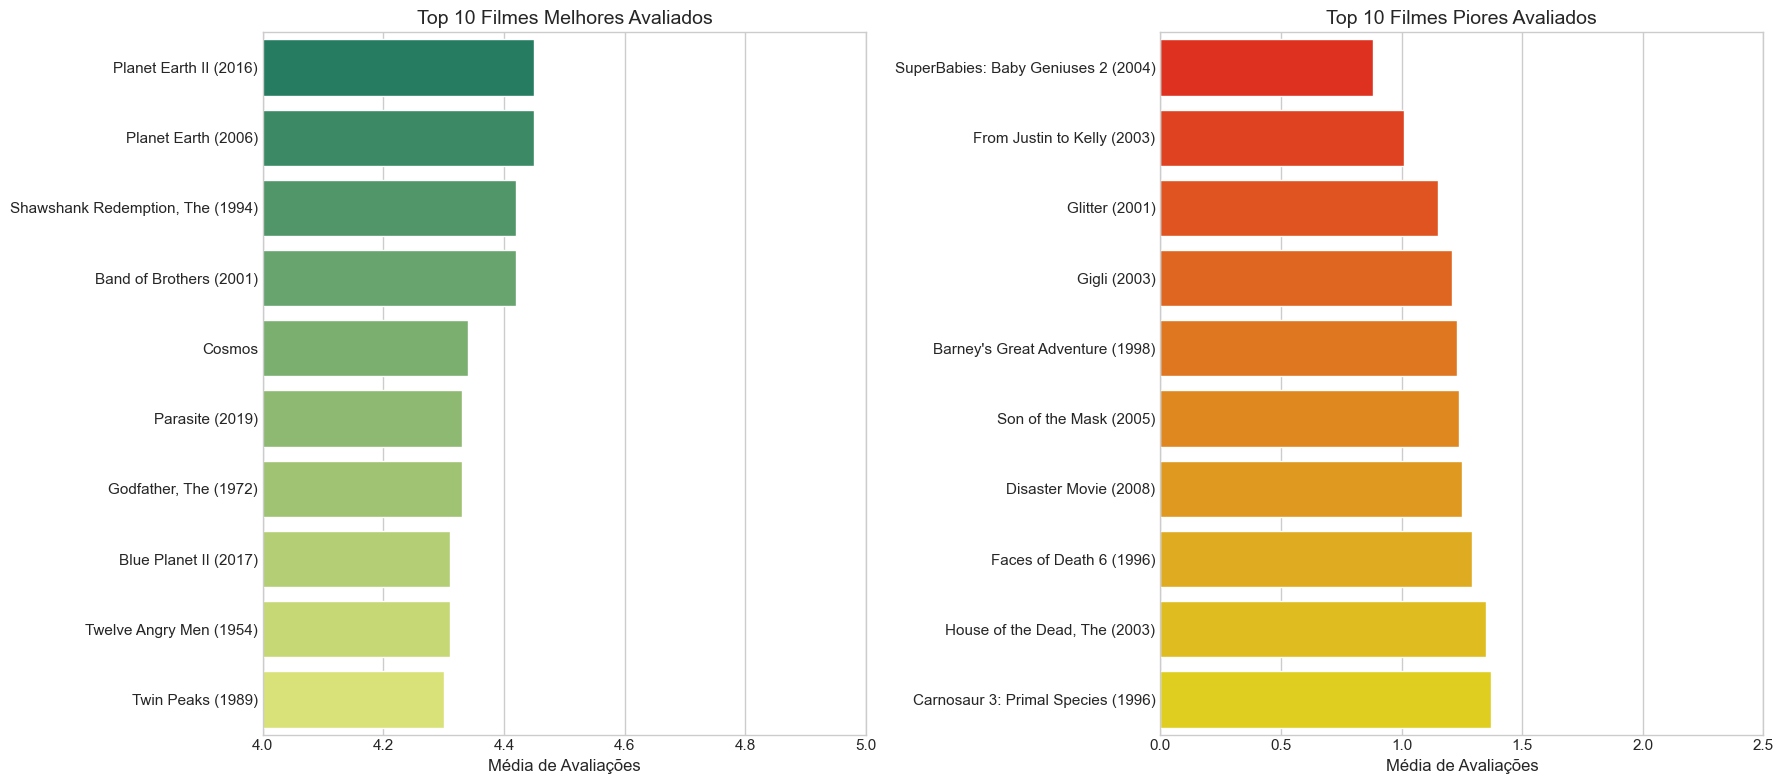

In [ ]:
# Melhores e piores filmes (com pelo menos 100 avaliações)
qualified_movies = movies[movies['num_ratings'] >= 100]

top_movies = qualified_movies.sort_values('avg_rating', ascending=False).head(10)
bottom_movies = qualified_movies.sort_values('avg_rating').head(10)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(x='avg_rating', y='title', hue='title', data=top_movies.reset_index(), ax=ax[0], palette='summer')
ax[0].set_title('Top 10 Filmes Melhores Avaliados', fontsize=14)
ax[0].set_xlabel('Média de Avaliações', fontsize=12)
ax[0].set_ylabel('')
ax[0].set_xlim(4, 5)

sns.barplot(x='avg_rating', y='title', hue='title', data=bottom_movies.reset_index(), ax=ax[1], palette='autumn')
ax[1].set_title('Top 10 Filmes Piores Avaliados', fontsize=14)
ax[1].set_xlabel('Média de Avaliações', fontsize=12)
ax[1].set_ylabel('')
ax[1].set_xlim(0, 2.5)

plt.tight_layout()
plt.show()


## **Observações:**
### - Filmes populares tendem a ser franquias conhecidas
### - Filmes com avaliações extremas geralmente têm menos avaliações
### - Há uma correlação positiva entre número de avaliações e nota média

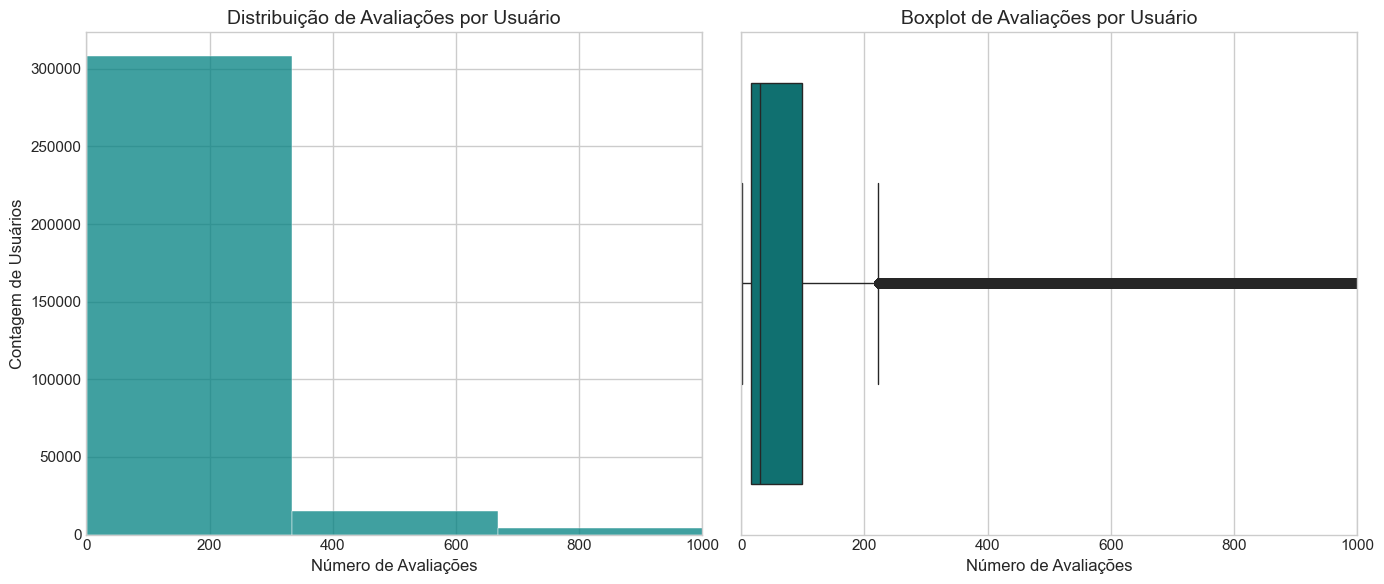

In [ ]:
# Distribuição de avaliações por usuário
user_activity = ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_activity, bins=100, color='teal')
plt.title('Distribuição de Avaliações por Usuário', fontsize=14)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.ylabel('Contagem de Usuários', fontsize=12)
plt.xlim(0, 1000)

plt.subplot(1, 2, 2)
sns.boxplot(x=user_activity, color='teal')
plt.title('Boxplot de Avaliações por Usuário', fontsize=14)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()



In [ ]:
print(f"👥 Usuários com menos de 10 avaliações: {len(user_activity[user_activity < 10]) / len(user_activity):.1%}")
print(f"🏆 Usuários com mais de 100 avaliações: {len(user_activity[user_activity > 100]) / len(user_activity):.1%}")

👥 Usuários com menos de 10 avaliações: 15.5%
🏆 Usuários com mais de 100 avaliações: 24.5%


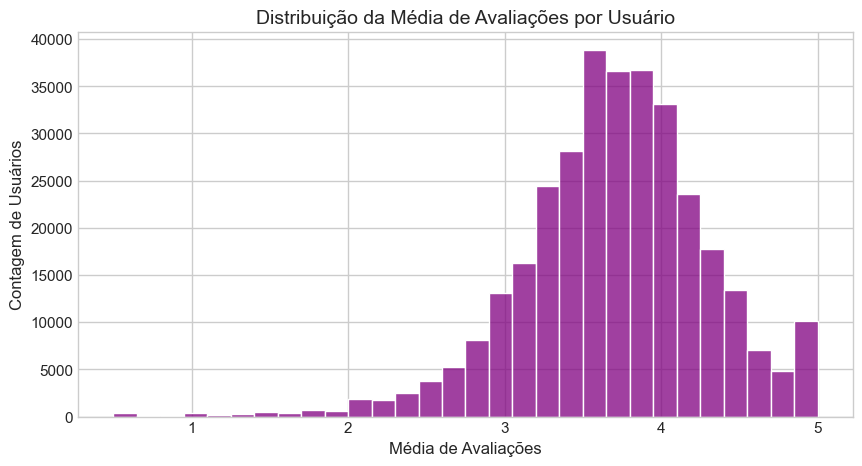

In [ ]:
# Média de avaliações por usuário
user_avg_rating = ratings.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 5))
sns.histplot(user_avg_rating, bins=30, color='purple')
plt.title('Distribuição da Média de Avaliações por Usuário', fontsize=14)
plt.xlabel('Média de Avaliações', fontsize=12)
plt.ylabel('Contagem de Usuários', fontsize=12)
plt.show()


## **Observações:**
### - A maioria dos usuários tem poucas avaliações (distribuição altamente assimétrica)
### - Poucos usuários são extremamente ativos
### - A média de avaliações por usuário segue distribuição normal

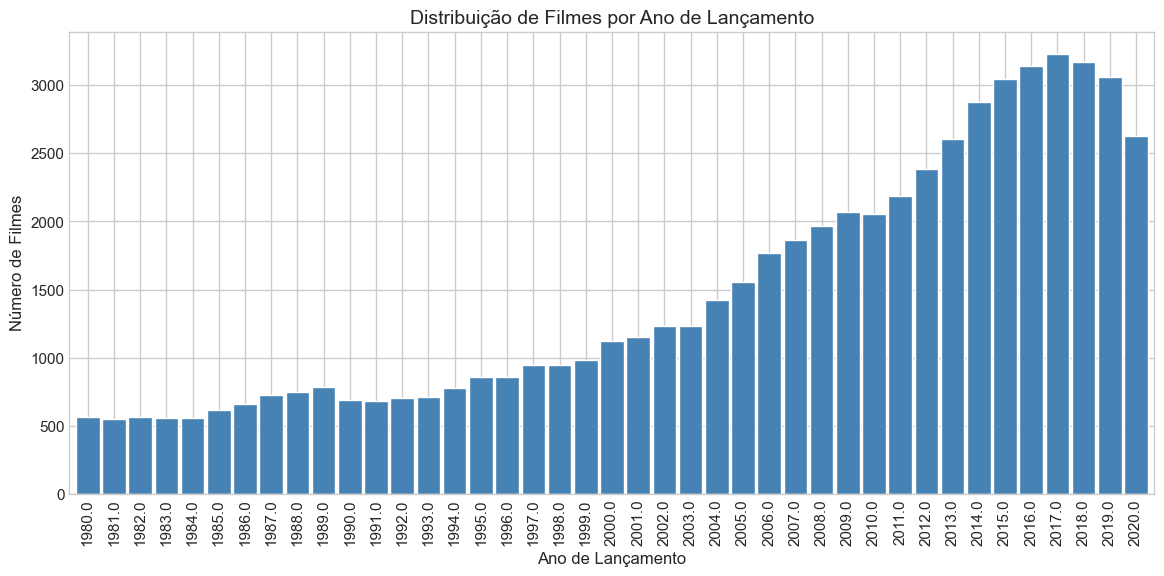

In [ ]:
# Extraindo ano do filme
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies_filtred = movies.copy()
movies_filtred = movies_filtred[(movies_filtred['year'] >= 1980) & (movies_filtred['year'] <= 2020)]

# Distribuição de filmes por ano
plt.figure(figsize=(14, 6))
movies_filtred['year'].value_counts().sort_index().plot(kind='bar', width=0.9, color='steelblue')
plt.title('Distribuição de Filmes por Ano de Lançamento', fontsize=14)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Número de Filmes', fontsize=12)
plt.show()


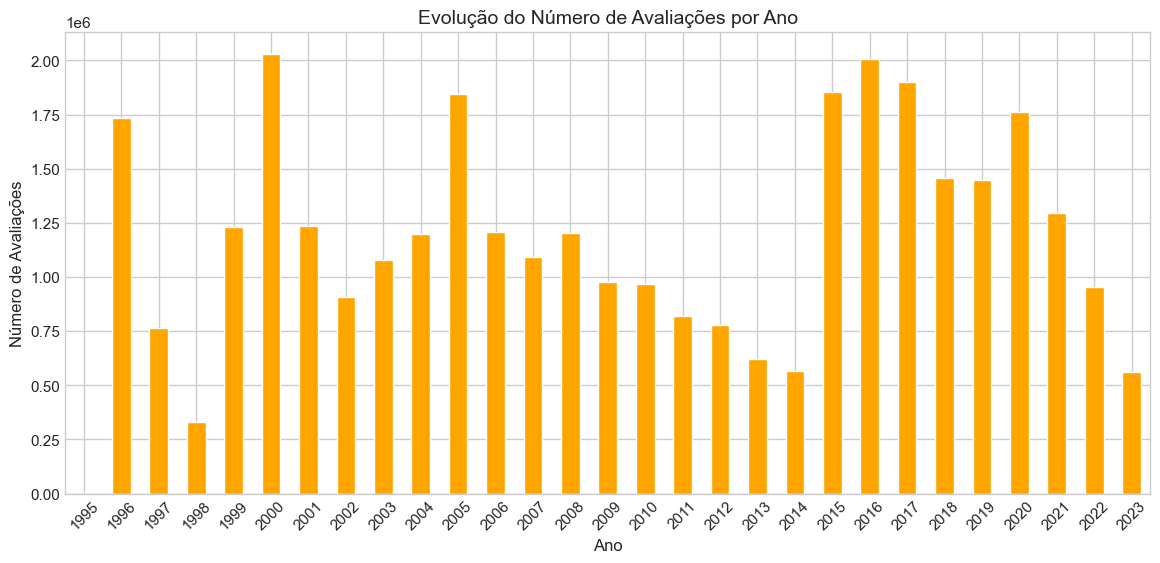

In [ ]:
# Evolução das avaliações ao longo do tempo
ratings['year'] = ratings['date'].dt.year
yearly_ratings = ratings.groupby('year').size()

plt.figure(figsize=(14, 6))
yearly_ratings.plot(kind='bar', color='orange')
plt.title('Evolução do Número de Avaliações por Ano', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Avaliações', fontsize=12)
plt.xticks(rotation=45)
plt.show()


## **Observações:**
### - Crescimento exponencial de filmes a partir dos anos 90
### - Pico de avaliações entre 2000-2005
### - Queda após 2010 possivelmente devido à migração para outras plataformas

In [ ]:
def popular_recommendations(min_ratings=100, n=10):
    """Recomenda filmes populares com base em avaliações"""
    qualified = movies[movies['num_ratings'] >= min_ratings]
    return qualified.sort_values(['avg_rating', 'num_ratings'], ascending=[False, False]).head(n)

print("🎬 Top 10 Filmes Populares:")
popular_recommendations()

🎬 Top 10 Filmes Populares:


,title,genres,number_of_ratings,average_ratings,num_ratings,avg_rating,year
movieId,,,,,,,
159817,Planet Earth (2006),Documentary,3015.0,4.45,3015.0,4.45,2006.0
171011,Planet Earth II (2016),Documentary,2041.0,4.45,2041.0,4.45,2016.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,122296.0,4.42,122296.0,4.42,1994.0
170705,Band of Brothers (2001),Action|Drama|War,2835.0,4.42,2835.0,4.42,2001.0
171495,Cosmos,(no genres listed),625.0,4.34,625.0,4.34,NaN
858,"Godfather, The (1972)",Crime|Drama,75004.0,4.33,75004.0,4.33,1972.0
202439,Parasite (2019),Comedy|Drama,12399.0,4.33,12399.0,4.33,2019.0
179135,Blue Planet II (2017),Documentary,1267.0,4.31,1267.0,4.31,2017.0
220528,Twelve Angry Men (1954),Drama,332.0,4.31,332.0,4.31,1954.0


In [ ]:
def genre_recommendations(genres, min_ratings=100, n=10):
    """Recomenda filmes com base em gêneros similares"""
    # Criar máscara para filmes que contêm todos os gêneros especificados
    mask = movies['genres'].apply(lambda x: all(genre in x for genre in genres))
    return movies[mask].query(f'num_ratings >= {min_ratings}').sort_values('avg_rating', ascending=False).head(n)

print("🔮 Recomendações para Fãs de Fantasia:")
genre_recommendations(['Fantasy'])


🔮 Recomendações para Fãs de Fantasia:


,title,genres,number_of_ratings,average_ratings,num_ratings,avg_rating,year
movieId,,,,,,,
5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,35375.0,4.23,35375.0,4.23,2001.0
163134,Your Name. (2016),Animation|Drama|Fantasy|Romance,3940.0,4.17,3940.0,4.17,2016.0
3000,Princess Mononoke (Mononoke-hime) (1997),Action|Adventure|Animation|Drama|Fantasy,18226.0,4.17,18226.0,4.17,1997.0
5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,14010.0,4.16,14010.0,4.16,1988.0
1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,47845.0,4.14,47845.0,4.14,1975.0
31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,16471.0,4.12,16471.0,4.12,2004.0
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi,263.0,4.12,263.0,4.12,2013.0
7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,75512.0,4.11,75512.0,4.11,2003.0
7099,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi,7596.0,4.11,7596.0,4.11,1984.0


In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Mapear usuários e filmes
user_mapper = {user: idx for idx, user in enumerate(ratings.index.unique())}
movie_mapper = {movie: idx for idx, movie in enumerate(ratings['movieId'].unique())}

# Criar índices numéricos
user_index = ratings.index.map(user_mapper).values
movie_index = ratings['movieId'].map(movie_mapper).values

# Verificação de comprimento
assert len(user_index) == len(movie_index) == len(ratings['rating']), "Comprimentos diferentes!"

# Criar matriz esparsa
rating_matrix = csr_matrix(
    (ratings['rating'].values, (user_index, movie_index)),
    shape=(len(user_mapper), len(movie_mapper))
)

# Treinar modelo KNN
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(rating_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
import numpy as np
import pandas as pd

# Criar um mapeamento inverso de índice para movie_id
inv_movie_mapper = {v: k for k, v in movie_mapper.items()}

def recommend_knn(user_id, n_recommendations=10):
    """Gera recomendações usando KNN"""

    user_idx = user_mapper.get(user_id)
    if user_idx is None:
        raise ValueError(f"Usuário {user_id} não encontrado.")

    # Encontrar vizinhos mais próximos
    distances, indices = knn_model.kneighbors(
        rating_matrix[user_idx],
        n_neighbors=6  # inclui o próprio usuário
    )

    # Filmes já vistos
    watched_movies = ratings.loc[ratings.index == user_id, 'movieId'].tolist()

    # Avaliações médias dos vizinhos (ignorando o próprio usuário)
    neighbor_indices = indices.flatten()[1:]  # ignora o próprio
    neighbor_ratings = rating_matrix[neighbor_indices].mean(axis=0).A1  # vetor de scores para cada filme

    # Mapeia de volta: índices de filmes → movieId
    all_movie_ids = [inv_movie_mapper[idx] for idx in range(len(inv_movie_mapper))]

    movie_scores = pd.DataFrame({
        'movieId': all_movie_ids,
        'score': neighbor_ratings
    })

    # Remove filmes já assistidos
    movie_scores = movie_scores[~movie_scores['movieId'].isin(watched_movies)]

    # Seleciona top-N
    top_movies = movie_scores.sort_values(by='score', ascending=False).head(n_recommendations)

    # Retorna informações dos filmes recomendados
    return movies.reindex(top_movies['movieId'])


In [ ]:
print("🤖 Recomendações KNN para Usuário 1:")
print(recommend_knn(1))

🤖 Recomendações KNN para Usuário 1:
                                                     title  \
movieId                                                      
1198     Raiders of the Lost Ark (Indiana Jones and the...   
527                                Schindler's List (1993)   
6377                                   Finding Nemo (2003)   
79132                                     Inception (2010)   
589                      Terminator 2: Judgment Day (1991)   
593                       Silence of the Lambs, The (1991)   
58559                              Dark Knight, The (2008)   
6333                               X2: X-Men United (2003)   
68358                                     Star Trek (2009)   
296                                    Pulp Fiction (1994)   

                                                  genres  number_of_ratings  \
movieId                                                                       
1198                                    Action|Adventure     

In [ ]:
# Criação do modelo KNN para itens (usando matriz transposta)
item_matrix = rating_matrix.T  # Transposta: filmes x usuários
knn_model_item = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model_item.fit(item_matrix)

def recommend_item_knn(movie_id, n_recommendations=10):
    """Gera recomendações baseadas na similaridade de itens (item-based KNN)"""
    try:
        # Verifica se o filme existe no mapeamento
        if movie_id not in movie_mapper:
            return pd.DataFrame(), []

        movie_idx = movie_mapper[movie_id]
        movie_vector = item_matrix[movie_idx]

        # Encontra filmes mais similares (incluindo o próprio)
        distances, indices = knn_model_item.kneighbors(
            movie_vector.reshape(1, -1),
            n_neighbors=n_recommendations + 1
        )

        # Remove o próprio filme dos resultados
        neighbor_indices = indices.flatten()[1:]

        # Mapeia índices para IDs de filmes
        recommended_movie_ids = [inv_movie_mapper[idx] for idx in neighbor_indices]

        # Recupera os dados dos filmes recomendados
        recommended_movies = movies.loc[recommended_movie_ids]

        return recommended_movies, recommended_movie_ids

    except Exception as e:
        print(f"Erro ao gerar recomendações: {e}")
        return pd.DataFrame(), []

In [ ]:
def plot_recommendations(user_id, recommendations):
    """Exibe gráfico com as recomendações"""
    # Verifica se o índice é 'movieId' e reseta para criar a coluna
    if recommendations.index.name == 'movieId':
        recommendations = recommendations.reset_index()

    # Se ainda não temos coluna 'movieId' mas o índice são IDs, usamos o índice
    if 'movieId' not in recommendations.columns and recommendations.index.name is None:
        recommendations = recommendations.reset_index().rename(columns={'index': 'movieId'})

    # Se recommendations só tem 'movieId' no índice, cria a coluna
    if 'movieId' not in recommendations.columns:
        recommendations = recommendations.reset_index()

    # Garante que temos a coluna 'movieId'
    if 'movieId' not in recommendations.columns:
        raise ValueError("DataFrame de recomendações não contém 'movieId'")

    # Pega as avaliações gerais desses filmes
    rec_ratings = ratings[ratings['movieId'].isin(recommendations['movieId'])]

    if rec_ratings.empty:
        print(f"Nenhuma avaliação encontrada para as recomendações do usuário {user_id}.")
        return

    # Criar DataFrame temporário com movieId e title (usando índice do movies)
    movies_temp = movies.reset_index()[['movieId', 'title']]

    # Agrupa e calcula a média das notas
    grouped = rec_ratings.merge(
        movies_temp,
        on='movieId',
        how='left'
    ).groupby('title')['rating'].mean().reset_index()

    if grouped.empty:
        print(f"Nenhum dado suficiente para plotar as recomendações do usuário {user_id}.")
        return

    # Ordena do mais bem avaliado
    grouped_sorted = grouped.sort_values('rating', ascending=False)

    # Plota
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x='rating',
        y='title',
        hue='title',
        data=grouped_sorted,
        palette='viridis'
    )

    plt.title(f'Recomendações para {user_id}')
    plt.xlabel('Média de Avaliações')
    plt.ylabel('Filmes Recomendados')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

def precision_recall_at_k(actual, predicted, k):
    predicted = predicted[:k]
    actual_set = set(actual)
    predicted_set = set(predicted)

    precision = len(actual_set & predicted_set) / len(predicted_set) if predicted_set else 0
    recall = len(actual_set & predicted_set) / len(actual_set) if actual_set else 0

    return precision, recall


🎬 Filmes similares ao filme 1:
                                                     title  \
movieId                                                      
3114                                    Toy Story 2 (1999)   
260              Star Wars: Episode IV - A New Hope (1977)   
780                   Independence Day (a.k.a. ID4) (1996)   
1270                             Back to the Future (1985)   
480                                   Jurassic Park (1993)   
364                                  Lion King, The (1994)   
356                                    Forrest Gump (1994)   
588                                         Aladdin (1992)   
1210     Star Wars: Episode VI - Return of the Jedi (1983)   
4886                                 Monsters, Inc. (2001)   

                                                  genres  number_of_ratings  \
movieId                                                                       
3114         Adventure|Animation|Children|Comedy|Fantasy          

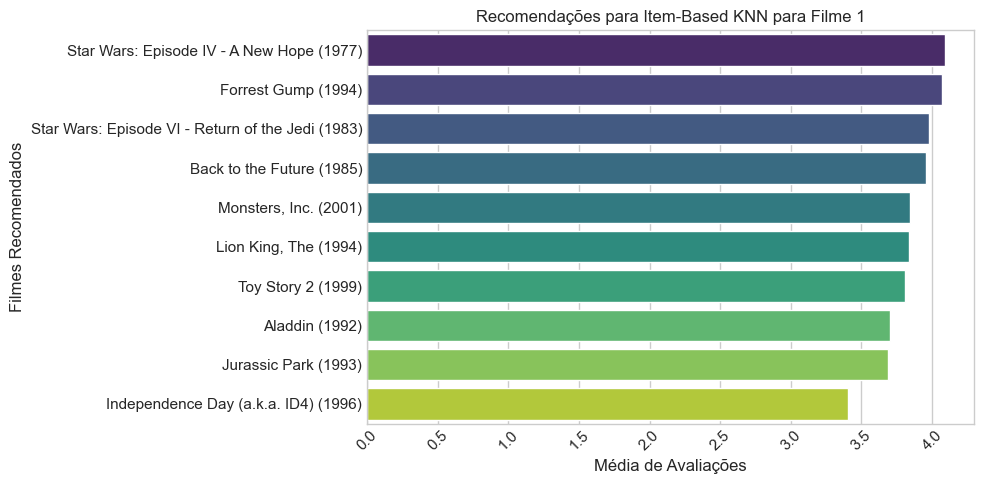

In [ ]:
print("🎬 Filmes similares ao filme 1:")
recommended_movies, movie_ids = recommend_item_knn(1)
print(recommended_movies)

# Plotagem dos resultados (se existirem recomendações)
if not recommended_movies.empty:
    plot_recommendations("Item-Based KNN para Filme 1", recommended_movies)
else:
    print("Nenhuma recomendação gerada para o filme 1")

# 4. Conclusão

## **Principais descobertas:**
### 1. O dataset mostra uma distribuição de avaliações com viés positivo
### 2. Usuários ativos são minoria mas contribuem com a maioria das avaliações
### 3. Filmes populares dominam as recomendações simples
### 4. O sistema KNN oferece recomendações personalizadas eficazes

## **Limitações e melhorias futuras:**
### - Implementar sistemas híbridos combinando conteúdo e colaboração
### - Utilizar técnicas de redução de dimensionalidade (SVD)
### - Incorporar informações demográficas dos usuários
### - Implementar deep learning com embeddings